# Gravity Density Model - Interactive Lab

Adapted from [gravity forward code](https://github.com/inlab-geo/inversion-test-problems/blob/main/GravityForward.ipynb) written in inversion-test-problems

In [47]:
%%capture
%run ./gravity_density.ipynb

In [48]:
import json
from contextlib import contextmanager
from cofi.solvers import solvers_table

# clear optional parameters
grav_problem.set_initial_model(None)
grav_problem.set_regularisation(reg_l1)
def depth_weight(z,z0,beta):
    return ((-z+z0)**(-beta/2))
beta=2

def adjust_problem(initial_model, z0, regularisation_factor):
    grav_problem.set_initial_model(initial_model)
    W=depth_weight(z_nodes[:,0],z0,beta)
    W=np.diag(W)
    grav_problem.set_regularisation(reg_l1, regularisation_factor)
    grav_problem.set_gradient(lambda m: data_misfit_gradient(m) + regularisation_factor*reg_gradient_l1(m))
    return grav_problem

def adjust_options(solving_method, tool, solver_params):
    inv_options = InversionOptions()
    inv_options.set_solving_method(solving_method)
    inv_options.set_tool(tool)
    inv_options.set_params(**solver_params)
    return inv_options

def plot_from_result(inv_result):
    result_model = inv_result.model.reshape(12,12,12)
    plt.imshow(result_model[::-1,5,:])
    plt.colorbar()

tmp_model = np.array(Starting_model1)
tmp_model[tmp_model>0] = 10
initial_models_table = {
    "Starting_model1": Starting_model1,
    "Starting_model2": Starting_model2,
    "Starting_model1(1000->10)": tmp_model,
    "all zeros": np.zeros((12**3)),
    "all ones": np.ones((12**3)),
}

def inversion(initial_model_id, z0, reg_factor, method, tool, solver_params):
    initial_model = initial_models_table[initial_model_id]
    grav_problem = adjust_problem(initial_model, z0, reg_factor)
    inv_options = adjust_options(method, tool, solver_params)
    inv_runner = InversionRunner(grav_problem, inv_options)
    result = inv_runner.run()
    # plot_from_result(result)
    return result

# inversion("Starting_model1", 1, "optimisation", "scipy.optimize.least_squares")

In [49]:
from ipywidgets import interactive
import ipywidgets as widgets

method_widget = widgets.ToggleButtons(options=solvers_table.keys(), description="method")
tool_widget = widgets.RadioButtons(options=solvers_table["optimisation"].keys(), description="tool")
initial_model_widget = widgets.RadioButtons(options=initial_models_table.keys(), value="all ones", description="intial_model")
z0_widget = widgets.FloatSlider(min=0, max=17, value=3, description="z0")
reg_factor_widget = widgets.FloatLogSlider(base=10,value=0.0001,min=-15,max=1,step=0.2, description="reg_factor")
solver_specific_params_widget = widgets.VBox(children=[])
run_widget = widgets.Button(description="Run Inversion")

def update_params_widgets(tool_solver):
    params_children = []
    required_in_options = tool_solver.required_in_options
    for param in required_in_options:
        params_children.append(widgets.Text(value="", placeholder="required", description=param))
    optional_in_options = tool_solver.optional_in_options
    for param, dft in optional_in_options.items():
        params_children.append(widgets.Text(value=str(dft), placeholder="optional", description=param))
    solver_specific_params_widget.children = params_children

def method_updated(*args):
    tool_widget.options = solvers_table[method_widget.value].keys()
method_widget.observe(method_updated, 'value')

def tool_updated(*args):
    tool = tool_widget.value
    tool_solver = solvers_table[method_widget.value][tool]
    required_in_problem = tool_solver.required_in_problem
    initial_model_widget.layout.visibility = "visible" if "initial_model" in required_in_problem else "hidden"
    reg_factor_widget.layout.visibility = "visible" if "objective" in required_in_problem else "hidden"
    update_params_widgets(tool_solver)
tool_widget.observe(tool_updated, 'value')
update_params_widgets(solvers_table["optimisation"]["scipy.optimize.minimize"])

def button_on_click(*args): 
    method = method_widget.value
    tool = tool_widget.value
    initial_model_id = initial_model_widget.value
    z0 = z0_widget.value
    reg_factor = reg_factor_widget.value
    solver_params = {}
    for widget in solver_specific_params_widget.children:
        val = widget.value
        if val == "None": val = None
        elif val == "True" or val == "true": val = True
        elif val == "False" or val == "False": val = False
        elif "{" in val and "}" in val: val = json.loads(val)
        else:
            try:
                val = float(val)
            except:
                pass
        solver_params[widget.description] = val
    with show_loading():
        res = inversion(initial_model_id, z0, reg_factor, method, tool, solver_params)
        args[0].result = res
        args[0].settings = {"initial_model":initial_model_id, "reg_factor":reg_factor, 
                            "method":method, "tool":tool, "solver_params":solver_params}
run_widget.on_click(button_on_click)

label = widgets.Label('Ready')
@contextmanager
def show_loading():
    label.value = 'Running...'
    yield
    label.value = 'Ready'

w = widgets.VBox(children=[method_widget, tool_widget, initial_model_widget, z0_widget, reg_factor_widget,
                          solver_specific_params_widget, run_widget, label])
display(w)

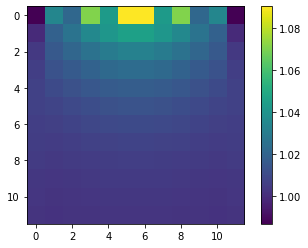

In [52]:
inv_res = run_widget.result
plot_from_result(inv_res)


---